In [239]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from RF_lib.RF_feature_importance import calculate_rfe_importance, train_and_evaluate, split_data

def robust_feature_ranking(model, X, y, perform_rfe=True, plot=True, color_mapping=None):
    performance_results = []
    shap_dict = {}
    rfe_results = []
    for train_index, test_index in split_data(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        result = train_and_evaluate(model, X_train, X_test, y_train, y_test)
        performance_results.append(result)

        # SHAP value computation with direction
        shap_importance = calculate_shap_importance(model, X_train, X_test)
        for feature, value in zip(shap_importance['Feature'], shap_importance['SHAP Value']):
            if feature in shap_dict:
                shap_dict[feature].append(value)
            else:
                shap_dict[feature] = [value]

        if perform_rfe:
            rfe_ranking = calculate_rfe_importance(model, X_train, y_train)
            rfe_results.append(rfe_ranking)

    if plot:
        plot_feature_importance(shap_dict, 'SHAP Importance')
        if perform_rfe:
            plot_feature_importance(rfe_results, 'RFE Ranking')

    return performance_results, shap_dict, rfe_results


def plot_feature_importance(importance_dict, title):
    # Convert the dictionary to a DataFrame with feature names, their mean importance, and standard deviation
    features = []
    means = []
    std_devs = []

    for k, v in importance_dict.items():
        features.append(k)
        means.append(np.mean(v))
        std_devs.append(np.std(v))  # Calculate standard deviation

    df = pd.DataFrame({'Feature': features, 'Importance': means, 'Std Dev': std_devs})
    
    # Sort the DataFrame by importance in descending order for better visualization
    df.sort_values(by='Importance', ascending=False, inplace=True)
    
    # Create a bar plot using Seaborn with features on the y-axis and error bars
    plt.figure(figsize=(10, len(df) / 2))  # Dynamically size the figure based on number of features
    sns.barplot(x='Importance', y='Feature', data=df, orient='h', color='skyblue', xerr=df['Std Dev'])
    
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

def calculate_shap_importance(model, X_train, X_test):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    shap_summaries = pd.DataFrame({
        'Feature': X_train.columns,
        'SHAP Value': np.abs(shap_values.values).mean(axis=0) * np.sign(shap_values.values).mean(axis=0)
    })
    shap_summaries.sort_values(by='SHAP Value', ascending=False, inplace=True)
    return shap_summaries

In [240]:
import RF_lib.RF_utils as rfut
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor


# Load your data (modify this part with real data loading)
csv_fn = r"Y:\ATD\GIS\East_Troublesome\Watershed Statistical Analysis\Watershed Stats\Channels\Channel Polygons\Channel Stats\csv\combined_attributes.csv"
variables_to_exclude = ['Erosion Mean',	'Erosion Sum',	'Erosion Count', 'Deposition Mean',	'Deposition Sum', 'Deposition Count',	
                        'Net Change', 'Net Change Norm', 'Distance Upstream', 'Distance Downstream', 'Slope Upstream', 'Slope Downstream',  'Elevation Mean',
                       'Sfm Deposition Mean', 'Sfm Deposition Sum', 'Sfm Deposition Count','Sfm Net Change', 'Sfm Net Change Norm',  'Sfm Erosion Mean', 'Sfm Erosion Sum', 'Sfm Erosion Count',
                       
                       'Width', 'Forward Slope Difference',	'Backward Slope Difference', 'Central Slope Difference',
                        'Area Central Diff', 'Curvature',  'Change in Slope Over Area',
                        #'Slope Over Area', 'Curvature Central Diff', 'Area', 'Flow Accumulation Max Central Diff', 'Slope Mean',
                        
                       #'Curvature', 'Curvature Central Diff', ,
                       #'Flow Accumulation Max', 
                    ] 

# ,		'Slope Mean',	'Area',	
# ,	'Width Central Diff',	'Flow Accumulation Max Central Diff',	
#  

#y_field = 'Net Change'
y_field = 'Erosion Mean'
#y_field = 'Deposition Mean'
count_fields = ['Erosion Count', 'Deposition Count']
#count_fields = ['Deposition Count']
count_fields = ['Erosion Count']
watershed_values = None

def load_data(file_path, exclude_vars, y_var):
    data = pd.read_csv(file_path)
    data = fill_inf_with_median(data)
    #drop rows where sum of count fields is less than 1
    data = data[data[count_fields].sum(axis=1) >= 1]
    X = data.drop(columns=exclude_vars)
    y = data[y_var].dropna()
    #drop rows where y contains NaN
    y = y.dropna()
    X = X.loc[y.index]
    #X = pd.get_dummies(X)  # Convert categorical columns to dummy variables
    X = X.loc[y.index]

    return X, y

def add_dummy_random_variables(X, n):
    for i in range(n):
        X['random_' + str(i)] = np.random.rand(X.shape[0])
    return X

def fill_NaN(df):
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            df[column] = df[column].fillna(df[column].mean())
    return df

def fill_inf_with_median(df):
    # Select only numeric columns for processing
    numeric_cols = df.select_dtypes(include=[np.number])
    
    for column in numeric_cols.columns:
        # Replace inf values with median
        if np.isinf(df[column]).sum() > 0:
            median_value = df[column].median()
            df[column] = df[column].replace([np.inf, -np.inf], np.nan).fillna(median_value)
    
    return df


def fill_NaN_with_value(X, value):
    for column in X.columns:
        if X[column].isnull().sum() > 0:
            X[column] = X[column].fillna(value)
    return X

def replace_excel_errors(X, fill_value=0):
    """
    Preprocesses the DataFrame by replacing non-numeric placeholder values,
    converting all data to floats, and filling missing values.

    Parameters:
    - X (pd.DataFrame): DataFrame containing the feature variables.
    - fill_value (numeric, optional): The value to use for filling missing values. Defaults to 0.

    Returns:
    - pd.DataFrame: The preprocessed DataFrame with numeric values only.
    """
    # Replace '#NAME?' and other placeholders with NaN
    X.replace(['#NAME?', '?', '--'], np.nan, inplace=True)

    # Convert all columns to numeric, forcing errors to NaN
    X = X.apply(pd.to_numeric, errors='coerce')

    # Fill missing values with a specified value or a strategy like mean or median
    X.fillna(fill_value, inplace=True)

    return X



# Load and prepare data
X, y = load_data(csv_fn, variables_to_exclude, y_field)
X = add_dummy_random_variables(X, 2)
#X = fill_NaN_with_value(X, 0)
#X = replace_excel_errors(X, 0)
#y = np.abs(y)

#print unqique values in Watershed field
print(X['Watershed'].unique())



['LM2' 'LPM' 'MM' 'MPM' 'UM1' 'UM2']


In [241]:
def split_data_by_watershed(X, y, watershed_field, test_watershed):
    """
    Split the data into training and testing sets based on a specified watershed value.

    Parameters:
    - X (pd.DataFrame): DataFrame containing feature variables.
    - y (pd.Series): Series containing the target variable.
    - watershed_field (str): The name of the column in X that specifies the watershed.
    - test_watershed (str): The value of the watershed to be used as the test set.

    Returns:
    - X_train (pd.DataFrame): Training set features.
    - X_test (pd.DataFrame): Test set features.
    - y_train (pd.Series): Training set target.
    - y_test (pd.Series): Test set target.
    """
    # Ensure that the watershed field is in the DataFrame
    if watershed_field not in X.columns:
        raise ValueError(f"The specified watershed field '{watershed_field}' is not in the DataFrame.")

    # Identify rows for the test set based on the watershed value
    test_mask = X[watershed_field] == test_watershed
    train_mask = ~test_mask
    
    # Split the data
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    
    
    return X_train, X_test, y_train, y_test


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#split training and testing data so testing data is where watershed = 'LPM'
X_train, X_test, y_train, y_test = split_data_by_watershed(X, y, 'Watershed', 'MM')
#drop 'Watershed' column from X_train and X_test
X_train = X_train.drop(columns='Watershed')
X_test = X_test.drop(columns='Watershed')
X = X.drop(columns='Watershed')

model = RandomForestRegressor(n_estimators=350, max_depth=18, min_samples_split=5, random_state=42)
#model = rfut.random_hyperparam_opt_RF(X_train, y_train)
#model = rfut.grid_hyperparam_opt_RF(X_train, y_train)
#model = rfut.bayesian_hyperparam_opt_RF(X_train, y_train)
#model = rfut.random_hyperparam_opt_XGB(X_train, y_train)
#model = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.07, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=18, min_samples_split=5, n_estimators=350,
                      random_state=42)


Mean of Erosion Mean: -0.7220072479832251
Standard Deviation of Erosion Mean: 0.32188273315212257

Test Set Performance:
Mean Squared Error: 0.39242290116200734
Root Mean Squared Error: 0.6264366697137128
R^2 Score: -2.8001385495


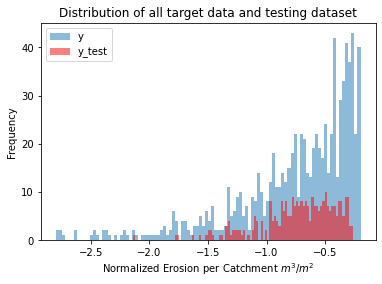

In [242]:
print(f"\nMean of {y_field}: {y_test.mean()}")
print(f"Standard Deviation of {y_field}: {y_test.std()}")
print("\nTest Set Performance:")
r2, mse, predictions = rfut.evaluate_model(model, X_test, y_test)

from RF_lib.RF_utils import plot_y_ytest_histogram
plot_y_ytest_histogram(y, y_test)

Mean Squared Error: 0.08329362514078963
Root Mean Squared Error: 0.28860634979291366
R^2 Score: 0.7204210721912896
Mean Squared Error: 0.09895010393242891
Root Mean Squared Error: 0.31456335440166727
R^2 Score: 0.5988865811070596
Mean Squared Error: 0.06993112100111097
Root Mean Squared Error: 0.26444492999698627
R^2 Score: 0.7283873434724655
Mean Squared Error: 0.06312277125515842
Root Mean Squared Error: 0.25124245512086213
R^2 Score: 0.7538211241003634
Mean Squared Error: 0.08038675221004125
Root Mean Squared Error: 0.283525575936354
R^2 Score: 0.6167615126574516


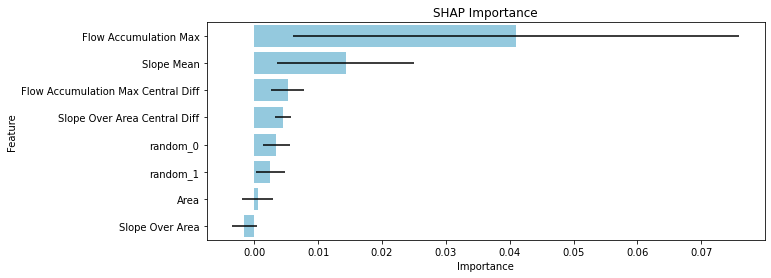

In [243]:
#from RF_lib.RF_feature_importance import robust_feature_ranking

model_performance, shap_dict, rfe_dict = robust_feature_ranking(model, X, y, perform_rfe = False, plot = True)

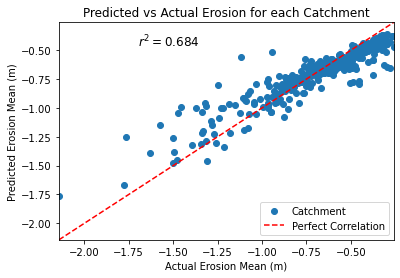

In [244]:
from RF_lib.RF_utils import plot_predictions
mean_score = np.mean([r['score'] for r in model_performance])
predictions = model.predict(X_test)
plot_predictions(y_test, predictions, mean_score, y_field)

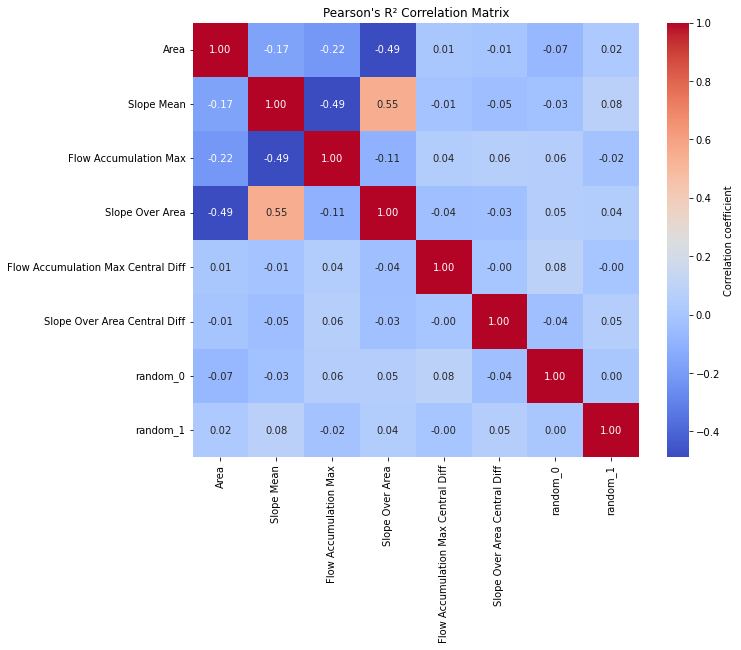

In [245]:
from RF_lib.RF_feature_importance import correlation_matrix_table

correlation_matrix_table(X_train)

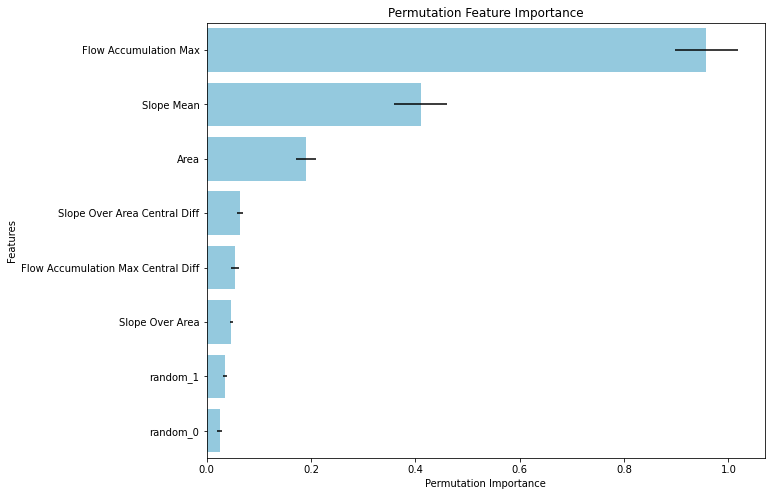

In [246]:
from RF_lib.RF_feature_importance import plot_permutation_importance

plot_permutation_importance(model, X_test, y_test, n_repeats=30)

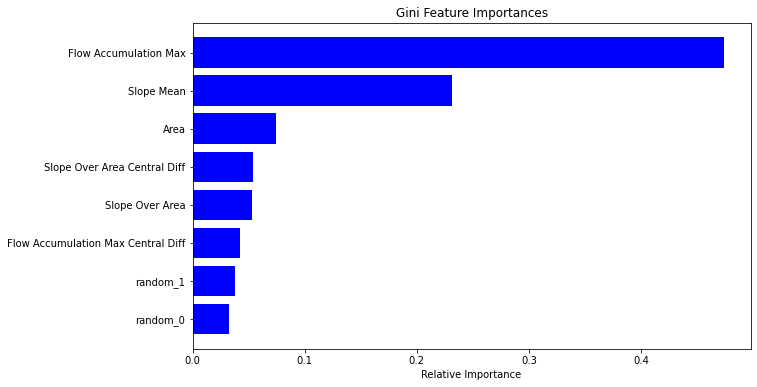

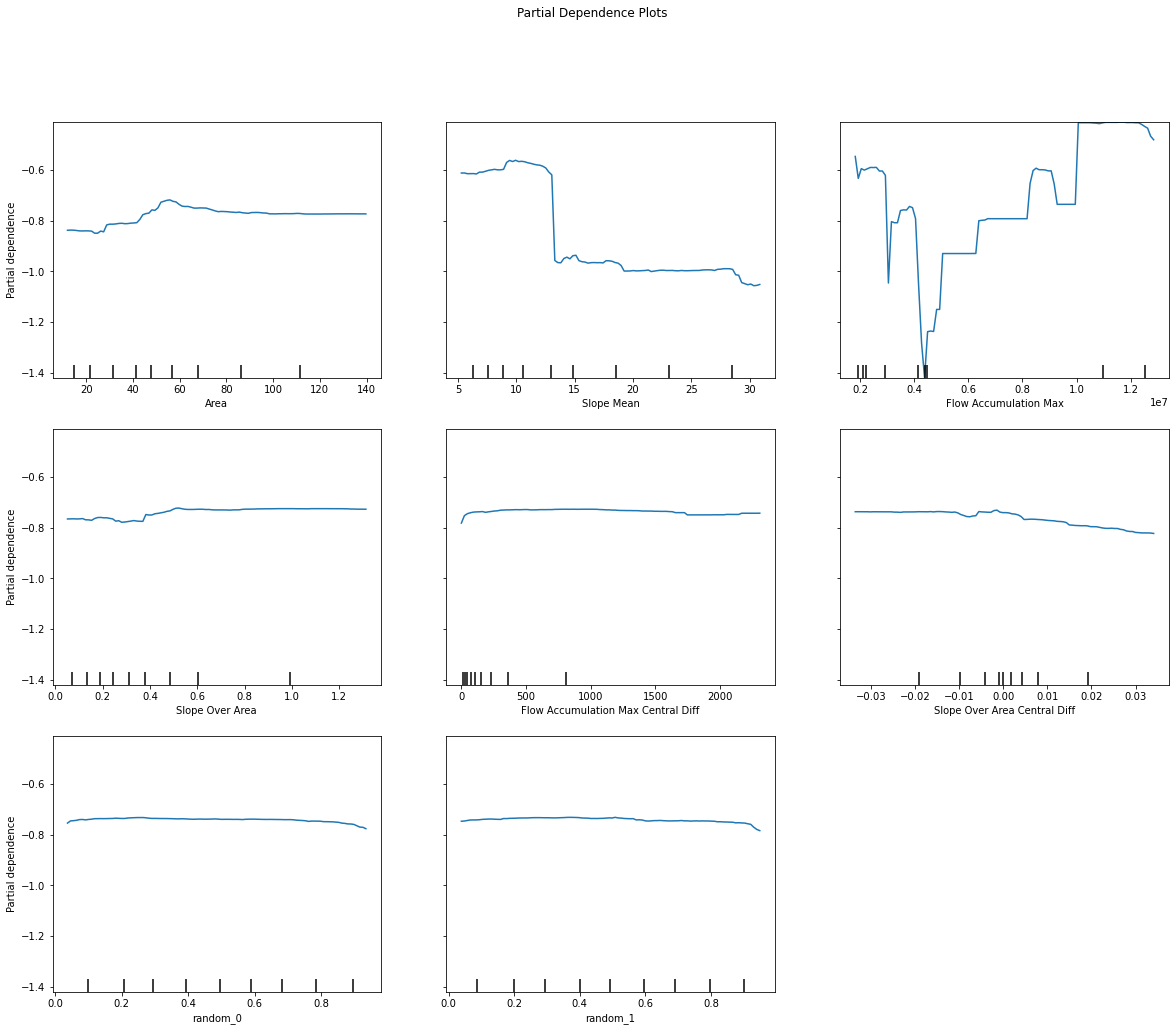

In [247]:
from RF_lib.RF_feature_importance import plot_Gini_feature_importances, partial_dependence_plots
#Gini Impurity Feature Importance Ranking
plot_Gini_feature_importances(model, X.columns)

#Partial Dependence Plots
feature_list = range(0, len(X.columns))
partial_dependence_plots(model, X_train, feature_list)

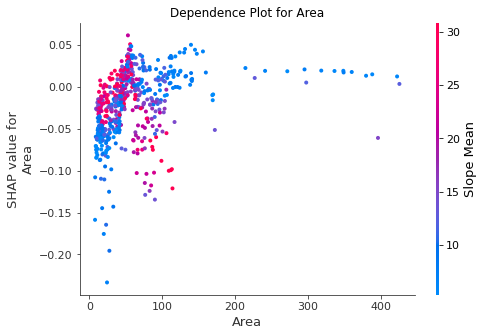

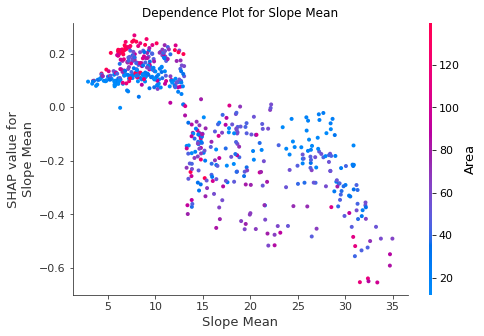

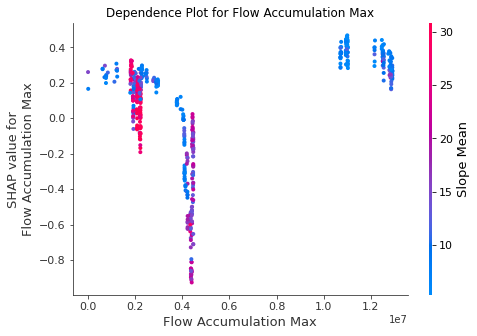

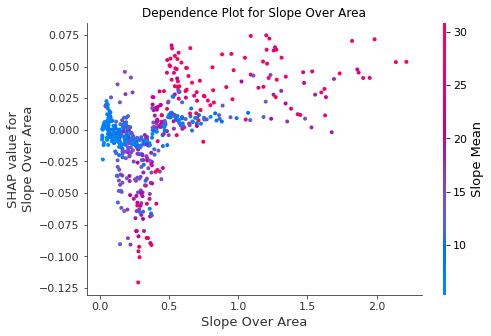

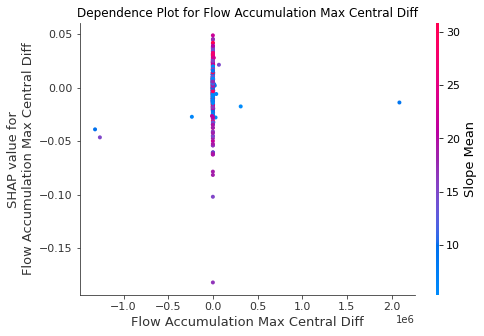

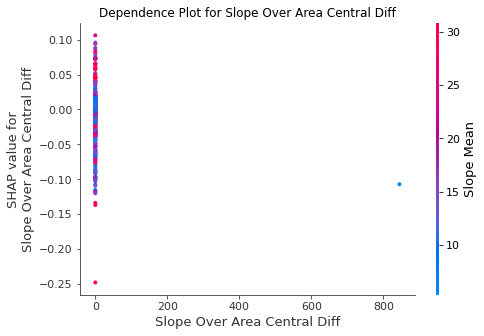

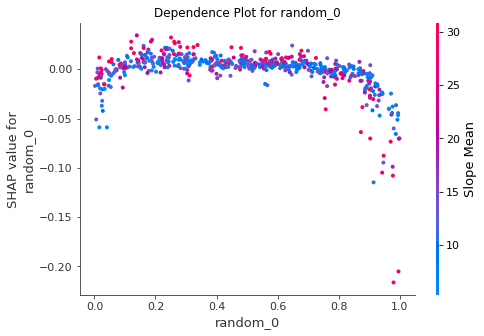

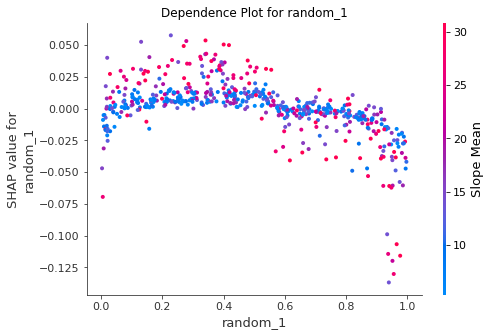

In [248]:
from RF_lib.RF_feature_importance import evaluate_feature_with_shap
feature_labels = X.columns
for feature in feature_labels:
    evaluate_feature_with_shap(model, X_train, X_test, feature)